# _LeNet-5_ CNN Learning Rate Schedulers: MNIST & PyTorch

[Guide to LR Schedulers in PyTorch](https://www.kaggle.com/code/isbhargav/guide-to-pytorch-learning-rate-scheduling/notebook)

In [ ]:
# Specify GPU to be used-
# %env CUDA_DEVICE_ORDER = PCI_BUS_ID
# %env CUDA_VISIBLE_DEVICES = 0

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from tqdm import tqdm
from tqdm import trange
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle

/home/arjunm/anaconda3/envs/torch-cpu/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print(f"torch version: {torch.__version__}")

torch version: 1.12.1


In [3]:
# Check if there are multiple devices (i.e., GPU cards)-
print(f"Number of GPU(s) available = {torch.cuda.device_count()}")

if torch.cuda.is_available():
    print(f"Current GPU: {torch.cuda.current_device()}")
    print(f"Current GPU name: {torch.cuda.get_device_name(torch.cuda.current_device())}")
else:
    print("PyTorch does not have access to GPU")

Number of GPU(s) available = 0
PyTorch does not have access to GPU


In [4]:
# Device configuration-
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Available device is {device}')

Available device is cpu


In [5]:
# MNIST dataset statistics-
mean = np.array([0.1307])
std_dev = np.array([0.3081])

# Apply transforms-
transforms_apply = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = mean, std = std_dev)
    ])

In [6]:
# MNIST dataset-
train_dataset = torchvision.datasets.MNIST(
        root = '/home/arjunm/Downloads/data', train = True,
        transform = transforms_apply, download = True
        )

test_dataset = torchvision.datasets.MNIST(
        root = '/home/arjunm/Downloads/data', train = False,
        transform = transforms_apply
        )

In [7]:
print(f"len(train_dataset): {len(train_dataset)} & len(test_dataset): {len(test_dataset)}")

len(train_dataset): 60000 & len(test_dataset): 10000


In [8]:
# Hyper-parameters-
num_epochs = 30
batch_size = 256
learning_rate = 0.001

In [9]:
# Create dataloader-
train_loader = torch.utils.data.DataLoader(
        dataset = train_dataset, batch_size = batch_size,
        shuffle = True
        )

test_loader = torch.utils.data.DataLoader(
        dataset = test_dataset, batch_size = batch_size,
        shuffle = False
        )

In [10]:
print(f"len(train_loader) = {len(train_loader)} & len(test_loader) = {len(test_loader)}")

len(train_loader) = 235 & len(test_loader) = 40


In [13]:
x, y = next(iter(train_loader))

In [14]:
x.min(), x.max()

(tensor(-0.4242), tensor(2.8215))

In [15]:
x.shape, y.shape

(torch.Size([256, 1, 28, 28]), torch.Size([256]))

In [17]:
x = x.permute((0, 2, 3, 1))
x.shape

torch.Size([256, 28, 28, 1])

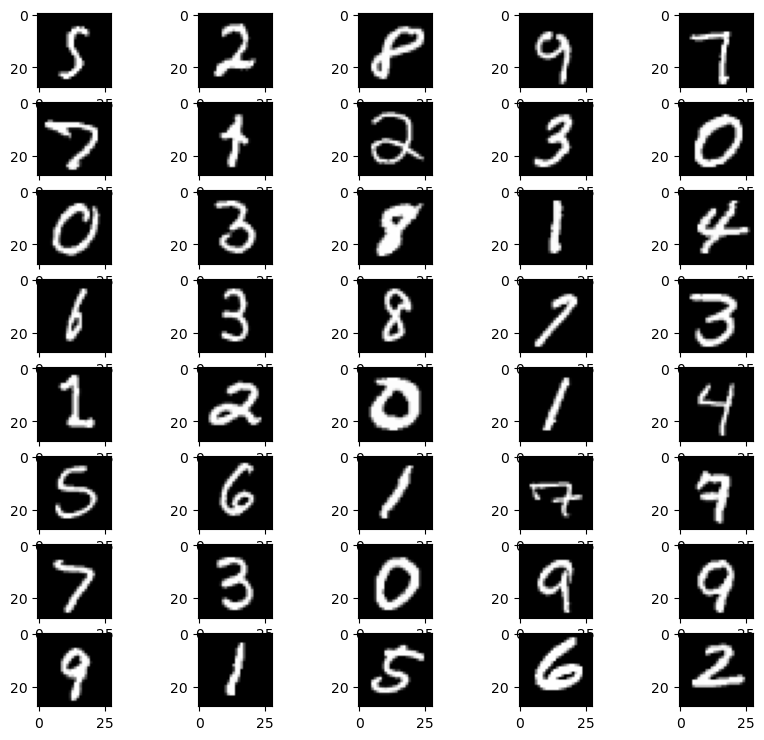

In [21]:
# Print images from training set-
plt.figure(figsize = (10, 9))
for i in range(40):
    plt.subplot(8, 5, i + 1)
    plt.imshow(x[i], cmap = 'gray')
plt.show()

In [26]:
del x, y

### _LeNet-5_ CNN architecture

- Use Batch normalization

- Use Sigmoid Linear Unit (SiLU)

In [11]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        
        self.conv1 = nn.Conv2d(
            in_channels = 1, out_channels = 6, 
            kernel_size = 5, stride = 1,
            padding = 0, bias = False 
        )
        self.bn1 = nn.BatchNorm2d(num_features = 6)
        self.pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.conv2 = nn.Conv2d(
            in_channels = 6, out_channels = 16,
            kernel_size = 5, stride = 1,
            padding = 0, bias = False
        )
        self.bn2 = nn.BatchNorm2d(num_features = 16)
        self.pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.fc1 = nn.Linear(
            in_features = 256, out_features = 120,
            bias = True
        )
        self.bn3 = nn.BatchNorm1d(num_features = 120)
        self.fc2 = nn.Linear(
            in_features = 120, out_features = 84,
            bias = True
        )
        self.bn4 = nn.BatchNorm1d(num_features = 84)
        self.fc3 = nn.Linear(
            in_features = 84, out_features = 10,
            bias = True
        )
        
        self.initialize_weights()

        
    def initialize_weights(self):
        for m in self.modules():
            # print(m)
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
                
                # Do not initialize bias (due to batchnorm)-
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
                
            elif isinstance(m, nn.BatchNorm2d):
                # Standard initialization for batch normalization-
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    
    def forward(self, x):
        x = nn.SiLU()(self.pool1(self.bn1(self.conv1(x))))
        x = nn.SiLU()(self.pool1(self.bn2(self.conv2(x))))
        x = x.view(-1, 256)
        x = nn.SiLU()(self.bn3(self.fc1(x)))
        x = nn.SiLU()(self.bn4(self.fc2(x)))
        x = self.fc3(x)
        return x
    

In [12]:
# Initialize an instance of LeNet-5 CNN architecture-
model = LeNet5().to(device)

In [13]:
# Sanity check-
x, y = next(iter(train_loader))

In [14]:
out = model(x)

In [15]:
out.shape

torch.Size([256, 10])

In [16]:
del x, y, out

In [13]:
# Count number of layer-wise parameters and total parameters-
tot_params = 0
for param in model.parameters():
    # print(f"layer.shape = {param.shape} has {param.nelement()} parameters")
    tot_params += param.nelement()

In [14]:
print(f"CNN model has {tot_params} parameters")

CNN model has 44856 parameters


In [15]:
# Define cost function-
loss = nn.CrossEntropyLoss()

In [16]:
# Defing SGD optimizer-
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)

In [17]:
print(f"number of train steps in one epoch = {np.ceil(len(train_loader.dataset) / batch_size)}")

number of train steps in one epoch = 235.0


#### ```MultiStepLR``` PyTorch

```
# Assuming optimizer uses lr = 0.05 for all groups
# lr = 0.05     if epoch < 30
# lr = 0.005    if 30 <= epoch < 80
# lr = 0.0005   if epoch >= 80
scheduler = MultiStepLR(optimizer, milestones=[30,80], gamma=0.1)
```

[MultiStepLR](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.MultiStepLR.html)

In [18]:
# Decay lr at 10th and 20th epochs by a factor of 10-
scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer = optimizer, milestones = [10, 20],
    gamma = 0.1
)

In [19]:
def train_one_step(model, train_loader, train_dataset):
    running_loss = 0.0
    running_corrects = 0.0
    
    model.to(device)
    model.train()
    
    with tqdm(train_loader, unit = 'batch') as tepoch:
        for images, labels in tepoch:
            tepoch.set_description(f"Training: ")
            
            images = images.to(device)
            labels = labels.to(device)
            
            # Get model predictions-
            outputs = model(images)
            
            # Compute loss-
            J = loss(outputs, labels)
            
            # Empty accumulated gradients-
            optimizer.zero_grad()
            
            # Perform backprop-
            J.backward()
            
            # Update parameters-
            optimizer.step()
            
            # Compute model's performance statistics-
            running_loss += J.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            running_corrects += torch.sum(predicted == labels.data)
            
            tepoch.set_postfix(
                loss = running_loss / len(train_dataset),
                accuracy = (running_corrects.double().cpu().numpy() / len(train_dataset)) * 100
            )
            
    
    train_loss = running_loss / len(train_dataset)
    train_acc = (running_corrects.double() / len(train_dataset)) * 100
    

    # return running_loss, running_corrects
    return train_loss, train_acc.detach().cpu().item()


In [20]:
def test_one_step(model, test_loader, test_dataset):
    total = 0.0
    correct = 0.0
    running_loss_val = 0.0
    
    model.to(device)
    model.eval()

    with torch.no_grad():
        with tqdm(test_loader, unit = 'batch') as tepoch:
            for images, labels in tepoch:
                tepoch.set_description(f"Validation: ")
                
                images = images.to(device)
                labels = labels.to(device)
                
                # Predict using trained model-
                outputs = model(images)
                _, y_pred = torch.max(outputs, 1)
                
                # Compute validation loss-
                J_val = loss(outputs, labels)
                
                running_loss_val += J_val.item() * labels.size(0)
    
                # Total number of labels-
                total += labels.size(0)

                # Total number of correct predictions-
                correct += (y_pred == labels).sum()
                
                tepoch.set_postfix(
                    val_loss = running_loss_val / len(test_dataset),
                    val_acc = 100 * (correct.cpu().numpy() / total)
                )
            
        
    # return (running_loss_val, correct, total)
    val_loss = running_loss_val / len(test_dataset)
    val_acc = (correct / total) * 100

    return val_loss, val_acc.detach().cpu().item()


In [21]:
# Python3 dict to contain training metrics-
train_history = {}

In [22]:
best_val_acc = 0

In [23]:
for epoch in range(1, num_epochs + 1):
    
    # One epoch of training-
    train_loss, train_acc = train_one_step(
        model = model, train_loader = train_loader,
        train_dataset = train_dataset
    )
    
    # Get validation metrics after 1 epoch of training-
    val_loss, val_acc = test_one_step(
        model = model, test_loader = test_loader,
        test_dataset = test_dataset
    )
    
    scheduler.step()
    
    current_lr = optimizer.param_groups[0]["lr"]
    
    print(f"Epoch: {epoch}; loss = {train_loss:.4f}, acc = {train_acc:.2f}%",
          f" val loss = {val_loss:.4f}, val acc = {val_acc:.2f}% & LR = {current_lr:.3f}"
         )
    
    # Save training metrics to Python3 dict-
    train_history[epoch] = {
        'train_loss': train_loss, 'val_loss': val_loss,
        'train_acc': train_acc, 'val_acc': val_acc,
        'lr': current_lr
    }
    
    # Save model with best validation accuracy-
    if (val_acc > best_val_acc):
        best_val_acc = val_acc
        print(f"Saving model with highest val_acc = {val_acc:.2f}%\n")
        torch.save(model.state_dict(), "LeNet5_MNIST_best_val_acc.pth")
        

Training: : 100%|█| 235/235 [00:08<00:00, 26.16batch/s, accuracy=65.3, loss=1.24
Validation: : 100%|█| 40/40 [00:01<00:00, 33.61batch/s, val_acc=87.7, val_loss=0


Epoch: 1; loss = 1.2353, acc = 65.32%  val loss = 0.6112, val acc = 87.68% & LR = 0.010
Saving model with highest val_acc = 87.68%



Training: : 100%|█| 235/235 [00:08<00:00, 26.49batch/s, accuracy=89, loss=0.507]
Validation: : 100%|█| 40/40 [00:01<00:00, 34.19batch/s, val_acc=91.7, val_loss=0


Epoch: 2; loss = 0.5067, acc = 89.05%  val loss = 0.3788, val acc = 91.70% & LR = 0.010
Saving model with highest val_acc = 91.70%



Training: : 100%|█| 235/235 [00:08<00:00, 26.43batch/s, accuracy=91.7, loss=0.35
Validation: : 100%|█| 40/40 [00:01<00:00, 31.47batch/s, val_acc=93.3, val_loss=0


Epoch: 3; loss = 0.3587, acc = 91.69%  val loss = 0.2882, val acc = 93.27% & LR = 0.010
Saving model with highest val_acc = 93.27%



Training: : 100%|█| 235/235 [00:08<00:00, 26.30batch/s, accuracy=93, loss=0.288]
Validation: : 100%|█| 40/40 [00:01<00:00, 33.17batch/s, val_acc=94.1, val_loss=0


Epoch: 4; loss = 0.2883, acc = 92.96%  val loss = 0.2391, val acc = 94.06% & LR = 0.010
Saving model with highest val_acc = 94.06%



Training: : 100%|█| 235/235 [00:09<00:00, 25.68batch/s, accuracy=93.9, loss=0.24
Validation: : 100%|█| 40/40 [00:01<00:00, 34.84batch/s, val_acc=94.8, val_loss=0


Epoch: 5; loss = 0.2461, acc = 93.86%  val loss = 0.2056, val acc = 94.76% & LR = 0.010
Saving model with highest val_acc = 94.76%



Training: : 100%|█| 235/235 [00:08<00:00, 26.33batch/s, accuracy=94.5, loss=0.21
Validation: : 100%|█| 40/40 [00:01<00:00, 34.88batch/s, val_acc=95.2, val_loss=0


Epoch: 6; loss = 0.2162, acc = 94.51%  val loss = 0.1849, val acc = 95.21% & LR = 0.010
Saving model with highest val_acc = 95.21%



Training: : 100%|█| 235/235 [00:09<00:00, 25.83batch/s, accuracy=95, loss=0.193]
Validation: : 100%|█| 40/40 [00:01<00:00, 33.63batch/s, val_acc=95.6, val_loss=0


Epoch: 7; loss = 0.1933, acc = 95.00%  val loss = 0.1652, val acc = 95.57% & LR = 0.010
Saving model with highest val_acc = 95.57%



Training: : 100%|█| 235/235 [00:09<00:00, 25.87batch/s, accuracy=95.4, loss=0.17
Validation: : 100%|█| 40/40 [00:01<00:00, 33.35batch/s, val_acc=95.8, val_loss=0


Epoch: 8; loss = 0.1760, acc = 95.36%  val loss = 0.1507, val acc = 95.84% & LR = 0.010
Saving model with highest val_acc = 95.84%



Training: : 100%|█| 235/235 [00:08<00:00, 26.69batch/s, accuracy=95.7, loss=0.16
Validation: : 100%|█| 40/40 [00:01<00:00, 35.86batch/s, val_acc=96.1, val_loss=0


Epoch: 9; loss = 0.1627, acc = 95.68%  val loss = 0.1404, val acc = 96.10% & LR = 0.010
Saving model with highest val_acc = 96.10%



Training: : 100%|█| 235/235 [00:08<00:00, 26.83batch/s, accuracy=96, loss=0.151]
Validation: : 100%|█| 40/40 [00:01<00:00, 34.51batch/s, val_acc=96.3, val_loss=0


Epoch: 10; loss = 0.1506, acc = 95.99%  val loss = 0.1298, val acc = 96.34% & LR = 0.001
Saving model with highest val_acc = 96.34%



Training: : 100%|█| 235/235 [00:08<00:00, 26.69batch/s, accuracy=96.2, loss=0.14
Validation: : 100%|█| 40/40 [00:01<00:00, 35.15batch/s, val_acc=96.4, val_loss=0


Epoch: 11; loss = 0.1442, acc = 96.17%  val loss = 0.1295, val acc = 96.35% & LR = 0.001
Saving model with highest val_acc = 96.35%



Training: : 100%|█| 235/235 [00:08<00:00, 26.61batch/s, accuracy=96.2, loss=0.14
Validation: : 100%|█| 40/40 [00:01<00:00, 35.03batch/s, val_acc=96.3, val_loss=0


Epoch: 12; loss = 0.1431, acc = 96.17%  val loss = 0.1291, val acc = 96.34% & LR = 0.001


Training: : 100%|█| 235/235 [00:08<00:00, 26.13batch/s, accuracy=96.2, loss=0.14
Validation: : 100%|█| 40/40 [00:01<00:00, 34.01batch/s, val_acc=96.4, val_loss=0


Epoch: 13; loss = 0.1431, acc = 96.19%  val loss = 0.1280, val acc = 96.37% & LR = 0.001
Saving model with highest val_acc = 96.37%



Training: : 100%|█| 235/235 [00:08<00:00, 26.63batch/s, accuracy=96.2, loss=0.14
Validation: : 100%|█| 40/40 [00:01<00:00, 34.07batch/s, val_acc=96.4, val_loss=0


Epoch: 14; loss = 0.1420, acc = 96.19%  val loss = 0.1270, val acc = 96.35% & LR = 0.001


Training: : 100%|█| 235/235 [00:08<00:00, 26.49batch/s, accuracy=96.3, loss=0.14
Validation: : 100%|█| 40/40 [00:01<00:00, 34.89batch/s, val_acc=96.4, val_loss=0


Epoch: 15; loss = 0.1404, acc = 96.26%  val loss = 0.1261, val acc = 96.44% & LR = 0.001
Saving model with highest val_acc = 96.44%



Training: : 100%|█| 235/235 [00:08<00:00, 26.45batch/s, accuracy=96.3, loss=0.14
Validation: : 100%|█| 40/40 [00:01<00:00, 34.41batch/s, val_acc=96.5, val_loss=0


Epoch: 16; loss = 0.1401, acc = 96.27%  val loss = 0.1259, val acc = 96.45% & LR = 0.001
Saving model with highest val_acc = 96.45%



Training: : 100%|█| 235/235 [00:09<00:00, 25.89batch/s, accuracy=96.2, loss=0.13
Validation: : 100%|█| 40/40 [00:01<00:00, 36.49batch/s, val_acc=96.4, val_loss=0


Epoch: 17; loss = 0.1394, acc = 96.25%  val loss = 0.1247, val acc = 96.40% & LR = 0.001


Training: : 100%|█| 235/235 [00:08<00:00, 26.67batch/s, accuracy=96.3, loss=0.13
Validation: : 100%|█| 40/40 [00:01<00:00, 36.31batch/s, val_acc=96.5, val_loss=0


Epoch: 18; loss = 0.1388, acc = 96.31%  val loss = 0.1239, val acc = 96.46% & LR = 0.001
Saving model with highest val_acc = 96.46%



Training: : 100%|█| 235/235 [00:08<00:00, 27.20batch/s, accuracy=96.3, loss=0.13
Validation: : 100%|█| 40/40 [00:01<00:00, 35.00batch/s, val_acc=96.5, val_loss=0


Epoch: 19; loss = 0.1371, acc = 96.33%  val loss = 0.1239, val acc = 96.52% & LR = 0.001
Saving model with highest val_acc = 96.52%



Training: : 100%|█| 235/235 [00:08<00:00, 26.66batch/s, accuracy=96.4, loss=0.13
Validation: : 100%|█| 40/40 [00:01<00:00, 37.03batch/s, val_acc=96.5, val_loss=0


Epoch: 20; loss = 0.1368, acc = 96.35%  val loss = 0.1224, val acc = 96.49% & LR = 0.000


Training: : 100%|█| 235/235 [00:08<00:00, 26.77batch/s, accuracy=96.4, loss=0.13
Validation: : 100%|█| 40/40 [00:01<00:00, 35.86batch/s, val_acc=96.5, val_loss=0


Epoch: 21; loss = 0.1360, acc = 96.38%  val loss = 0.1232, val acc = 96.48% & LR = 0.000


Training: : 100%|█| 235/235 [00:08<00:00, 26.61batch/s, accuracy=96.3, loss=0.13
Validation: : 100%|█| 40/40 [00:01<00:00, 35.16batch/s, val_acc=96.5, val_loss=0


Epoch: 22; loss = 0.1365, acc = 96.32%  val loss = 0.1228, val acc = 96.47% & LR = 0.000


Training: : 100%|█| 235/235 [00:08<00:00, 26.45batch/s, accuracy=96.4, loss=0.13
Validation: : 100%|█| 40/40 [00:01<00:00, 36.25batch/s, val_acc=96.5, val_loss=0


Epoch: 23; loss = 0.1355, acc = 96.40%  val loss = 0.1217, val acc = 96.46% & LR = 0.000


Training: : 100%|█| 235/235 [00:08<00:00, 26.46batch/s, accuracy=96.4, loss=0.13
Validation: : 100%|█| 40/40 [00:01<00:00, 35.70batch/s, val_acc=96.5, val_loss=0


Epoch: 24; loss = 0.1355, acc = 96.35%  val loss = 0.1223, val acc = 96.49% & LR = 0.000


Training: : 100%|█| 235/235 [00:08<00:00, 27.00batch/s, accuracy=96.3, loss=0.13
Validation: : 100%|█| 40/40 [00:01<00:00, 36.46batch/s, val_acc=96.5, val_loss=0


Epoch: 25; loss = 0.1352, acc = 96.33%  val loss = 0.1230, val acc = 96.48% & LR = 0.000


Training: : 100%|█| 235/235 [00:08<00:00, 26.83batch/s, accuracy=96.4, loss=0.13
Validation: : 100%|█| 40/40 [00:01<00:00, 32.98batch/s, val_acc=96.5, val_loss=0


Epoch: 26; loss = 0.1355, acc = 96.41%  val loss = 0.1216, val acc = 96.48% & LR = 0.000


Training: : 100%|█| 235/235 [00:08<00:00, 26.60batch/s, accuracy=96.4, loss=0.13
Validation: : 100%|█| 40/40 [00:01<00:00, 36.29batch/s, val_acc=96.5, val_loss=0


Epoch: 27; loss = 0.1355, acc = 96.37%  val loss = 0.1228, val acc = 96.49% & LR = 0.000


Training: : 100%|█| 235/235 [00:08<00:00, 26.92batch/s, accuracy=96.4, loss=0.13
Validation: : 100%|█| 40/40 [00:01<00:00, 34.93batch/s, val_acc=96.5, val_loss=0


Epoch: 28; loss = 0.1353, acc = 96.38%  val loss = 0.1219, val acc = 96.54% & LR = 0.000
Saving model with highest val_acc = 96.54%



Training: : 100%|█| 235/235 [00:08<00:00, 26.80batch/s, accuracy=96.3, loss=0.13
Validation: : 100%|█| 40/40 [00:01<00:00, 35.65batch/s, val_acc=96.5, val_loss=0


Epoch: 29; loss = 0.1357, acc = 96.34%  val loss = 0.1228, val acc = 96.50% & LR = 0.000


Training: : 100%|█| 235/235 [00:08<00:00, 26.22batch/s, accuracy=96.4, loss=0.13
Validation: : 100%|█| 40/40 [00:01<00:00, 36.08batch/s, val_acc=96.5, val_loss=0

Epoch: 30; loss = 0.1355, acc = 96.37%  val loss = 0.1215, val acc = 96.47% & LR = 0.000


In [24]:
# Save training metrics as pickled object-
with open("LeNet5_MNIST_training_history.pkl", "wb") as file:
    pickle.dump(train_history, file)

### Training Visualizations

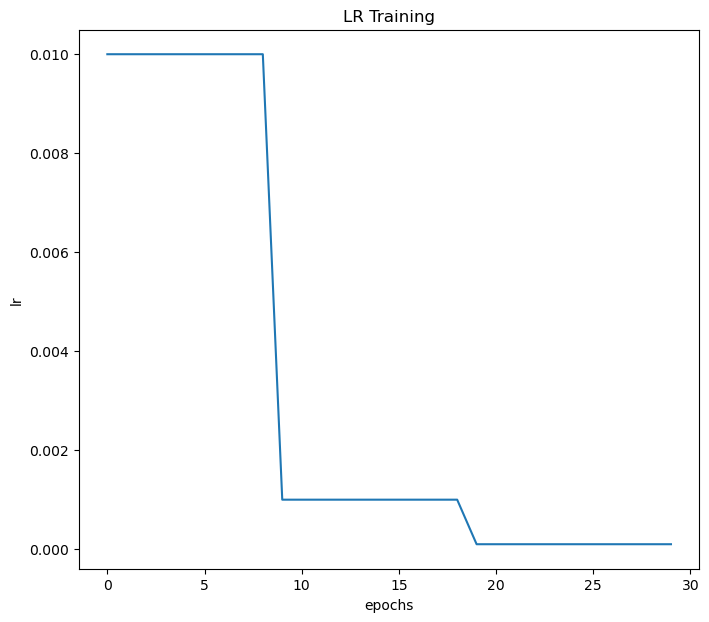

In [25]:
plt.figure(figsize = (8, 7))
plt.plot([train_history[e]['lr'] for e in train_history.keys()])
plt.xlabel("epochs")
plt.ylabel("lr")
plt.title("LR Training")
plt.show()

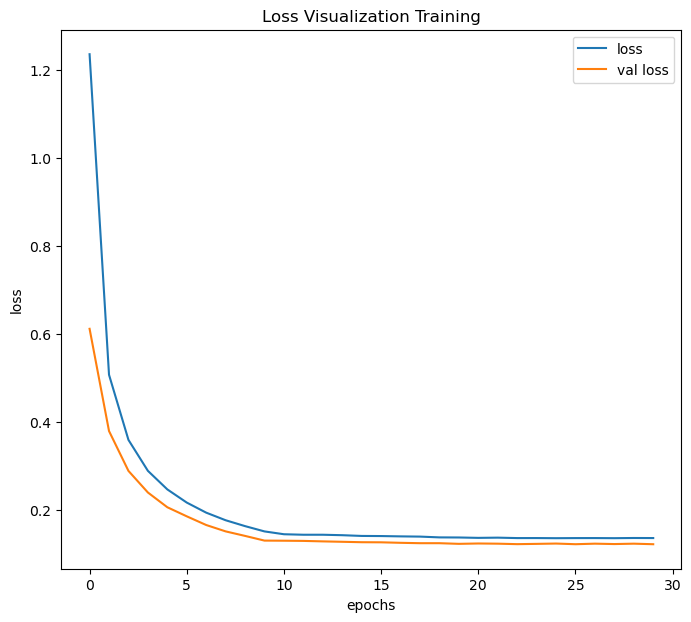

In [26]:
plt.figure(figsize = (8, 7))
plt.plot([train_history[e]['train_loss'] for e in train_history.keys()], label = 'loss')
plt.plot([train_history[e]['val_loss'] for e in train_history.keys()], label = 'val loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Loss Visualization Training")
plt.legend(loc = 'best')
plt.show()

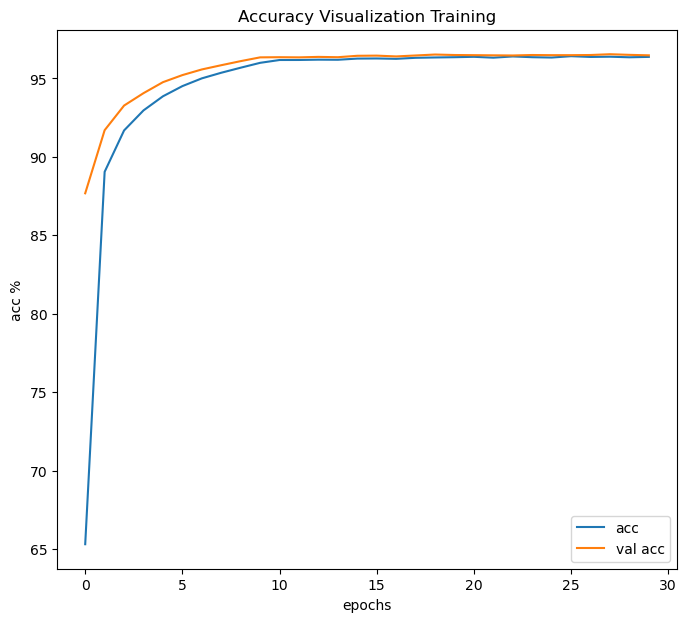

In [27]:
plt.figure(figsize = (8, 7))
plt.plot([train_history[e]['train_acc'] for e in train_history.keys()], label = 'acc')
plt.plot([train_history[e]['val_acc'] for e in train_history.keys()], label = 'val acc')
plt.xlabel("epochs")
plt.ylabel("acc %")
plt.title("Accuracy Visualization Training")
plt.legend(loc = 'best')
plt.show()